In [29]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

In [30]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170

# bycode 2018 excel
BYCODE = os.path.join(ROOT_PATH,"bycode2018.xlsx")

# index 2018 excel
INDEX = os.path.join(ROOT_PATH,"index 2018.xlsx")
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement type"


# elections data
SETTELMENT21 = os.path.join(ROOT_PATH,"21settelments.xlsx")
SETTELMENT22 = os.path.join(ROOT_PATH,"22settelments.xlsx")
SETTELMENT23 = os.path.join(ROOT_PATH,"23settelments.xlsx")


# Data cleaning and filling
#### remove irevelant columns and rows
###### year - column that has only one value 2018
###### rows of NA will be removed

def f(x):
    """a docstring"""
    return x**2

In [31]:
bycode = pd.read_excel(BYCODE,dtype=object)
bycode.drop("year",axis = 1,inplace = True)
bycode.drop("Metropolitan association",axis = 1,inplace = True)


bycode =bycode[bycode["name"].str.contains("NA") == False]
bycode.drop("name",axis=1, inplace = True)
bycode.drop("Status Montzifali",axis=1,inplace=True)

#### fill the columns
###### fill Religion "nan" values with class 0 that represents undefined religion
###### fill Established year with the average year in column

In [32]:
# fill established with most frequent year
bycode["Established"] = pd.to_numeric(bycode["Established"],errors='coerce')
bycode["Established"] = bycode["Established"].fillna(bycode["Established"].value_counts().idxmax())
bycode["Established"] = bycode["Established"].astype(int)

#fill total popluation with median population
bycode["Total population in 2018"] = pd.to_numeric(bycode["Total population in 2018"],errors='coerce')
bycode["Total population in 2018"] = bycode["Total population in 2018"].fillna(bycode["Total population in 2018"].median())
bycode["Total population in 2018"] = bycode["Total population in 2018"].astype(int)

#fill arabs, jews, and other
arabs_code = [250,260,270,280,290,440,450,460]

for index,row in bycode.iterrows():

    if row['Settlement type code'] in arabs_code and pd.isnull(row['Jews and others']):
        bycode.at[index,"Jews and others"] = "0"
        bycode.at[index,"Thereof: Jews"] = "0"
        bycode.at[index,"Arabs"] = row["Total population in 2018"]

    elif row['Settlement type code'] not in arabs_code and pd.isnull(row['Jews and others']):
        bycode.at[index,"Jews and others"] = row["Total population in 2018"]
        bycode.at[index,"Thereof: Jews"] = row["Total population in 2018"]
        bycode.at[index,"Arabs"] = "0"


bycode["Arabs"].fillna("0",inplace = True)
bycode["Thereof: Jews"].fillna("0",inplace = True)
bycode["Jews and others"].fillna("0",inplace = True)

# fill height
bycode["height"].fillna(bycode["height"].value_counts().idxmax(),inplace = True)   

#fill Organizational affiliation
bycode["Organizational affiliation code"].fillna("19",inplace = True)

#fill Natural area code
for index,row in bycode.iterrows():
    if  pd.isnull(row['Natural area code']):
        if row["District code"] == 11:
            bycode.at[index,"Natural area code"] = "111"
        elif row["District code"] in [21,22,23,24,25,29]:
            bycode.at[index,"Natural area code"] = "211"
        elif row["District code"] == [31,32]:
            bycode.at[index,"Natural area code"] = "311"
        elif row["District code"] == [41,42,43,44]:
            bycode.at[index,"Natural area code"] = "411"
        elif row["District code"] == [51,52,53]:
            bycode.at[index,"Natural area code"] = "511"
        elif row["District code"] == [61,62]:
            bycode.at[index,"Natural area code"] = "611"
        
        else:
            bycode.at[index,"Natural area code"] = "0"

#fill Local authorities
bycode["Local authorities code"].fillna(0,inplace = True)

# fill Religion
for index,row in bycode.iterrows():
    if pd.isnull(row['Religion code']):
        if row["Arabs"] == "0":
            bycode.at[index,"Religion code"] = "1"
        else:
            bycode.at[index,"Religion code"] = "2"

In [33]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

### Dataframe Manipulation Functions

In [34]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    return pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)

def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

def normalize_to_voting_ratios(df_original):
    """normalizing the votes according to proportion of votes per party"""
   
    columns = ['Haredi','Right','Arab','Left','Likud','Blue and white']
    df = df_original.copy()
    df = df[columns].astype(float)
    
    
    for i,r in df_original.iterrows():
        for c in columns:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
            
    return df[columns]

def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp = temp[['Haredi','Right','Arab','Left','Likud','Blue and white']]
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

### Ploting Functions

In [36]:
def barchar_group(df,x_var,groupby_var,size,name):
    """creates a barchar that represents aggregation results"""
    
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=False, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(name, fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, size)
    plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def pca_conversion(vectors):
    """ PCA conversion for visualiztion"""
    pca = decomposition.PCA(n_components=3)
    pca.fit(vectors)
    vectors_vis = pca.transform(vectors)
    vectors_vis = pd.DataFrame(vectors_vis,columns = ["x","y","z"])
    return vectors_vis

In [37]:
le = LabelEncoder()
index = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
df_21 = pd.read_excel(SETTELMENT21,dtype=object)

df_21 = remove_small_parties(df_21,135720)
df_21 = unite_parties(df_21)
df_21 = add_most_voted_colm(df_21)
df_21 = inner_join(df_21,bycode,"code")
df_21 = inner_join(df_21,index,"Settlement type code")
df_21.fillna(0,inplace = True)

df_base = df_21[["Likud","Blue and white",'Haredi','Right','Arab','Left',"chosen","Settlement type","valid votes"]]

In [38]:
df = df_base.copy()
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df["chosen"] = le.fit_transform(df['chosen'])
df.astype(int,copy = False)

,Likud,Blue and white,Haredi,Right,Arab,Left,chosen,Settlement type,valid votes
0,141,99,35,52,0,26,4,4,371
1,124,5,76,23,0,5,4,4,235
2,84,111,2,37,0,31,1,4,288
3,26,250,4,34,0,61,1,4,403
4,165,5,29,8,0,1,4,4,215
...,...,...,...,...,...,...,...,...,...
1119,29569,10974,5944,17025,44,1740,4,14,69394
1120,21142,22390,6853,12514,122,5787,1,14,73125
1121,21512,37224,3204,9448,232,10195,1,14,86756
1122,64380,30576,96405,38518,2147,16194,2,14,260049


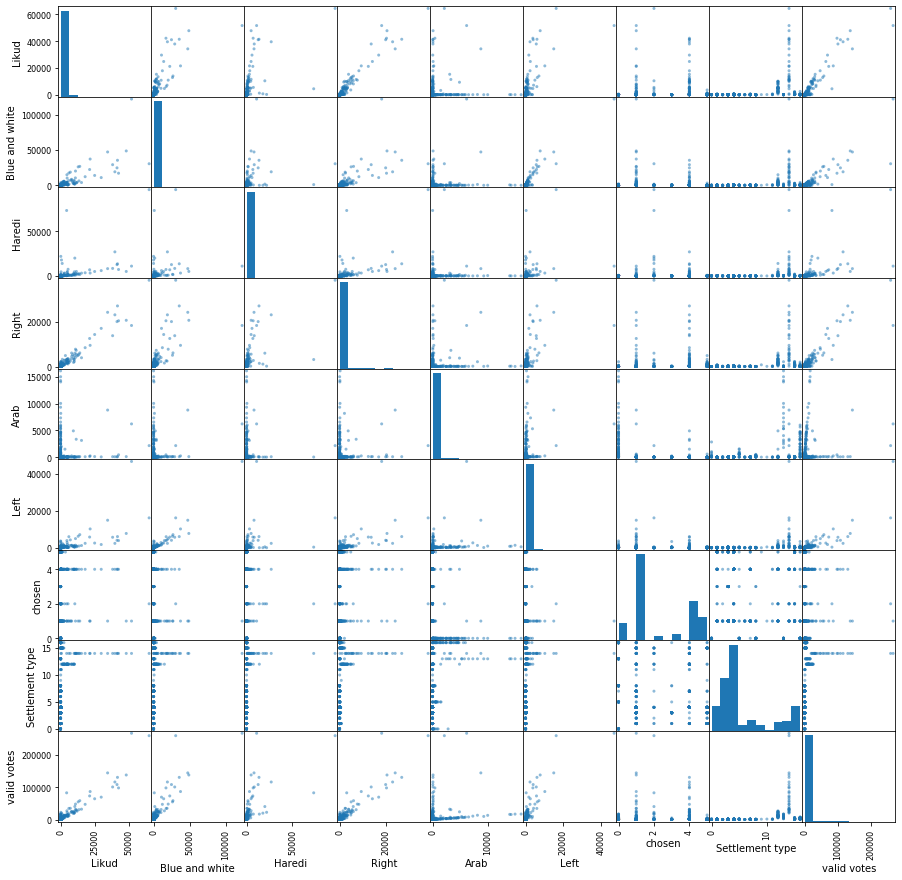

      Likud  Blue and white  Haredi  Right   Arab   Left  chosen  \
0     False           False   False  False  False  False   False   
1     False           False   False  False  False  False   False   
2     False           False   False  False  False  False   False   
3     False           False   False  False  False  False   False   
4     False           False   False  False  False  False   False   
...     ...             ...     ...    ...    ...    ...     ...   
1119  False           False   False  False  False  False   False   
1120  False           False   False  False  False  False   False   
1121  False           False   False  False  False  False   False   
1122  False           False   False  False  False  False   False   
1123  False           False   False  False  False  False   False   

      Settlement type  valid votes  
0               False        False  
1               False        False  
2               False        False  
3               False        False 

In [39]:
pd.plotting.scatter_matrix(df,  figsize=(15, 15))
plt.show()

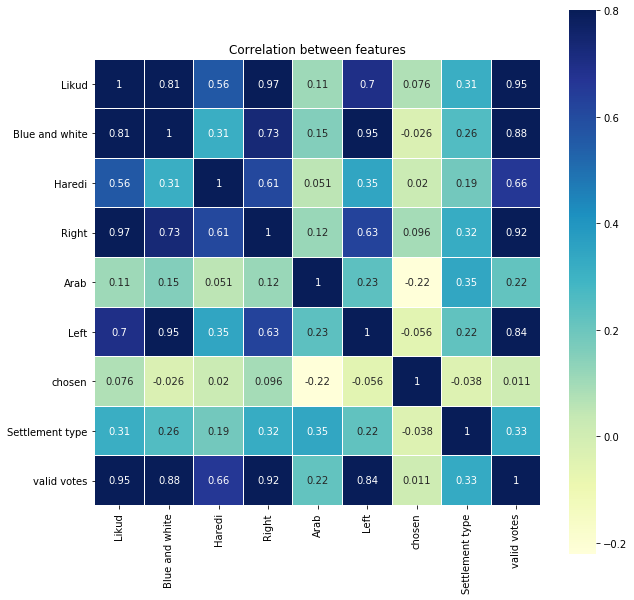

In [40]:
corr=df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

# Question 3

In [41]:
df_normalized = normalize_to_voting_ratios(df_base)
vectors_vis = pca_conversion(df_normalized)

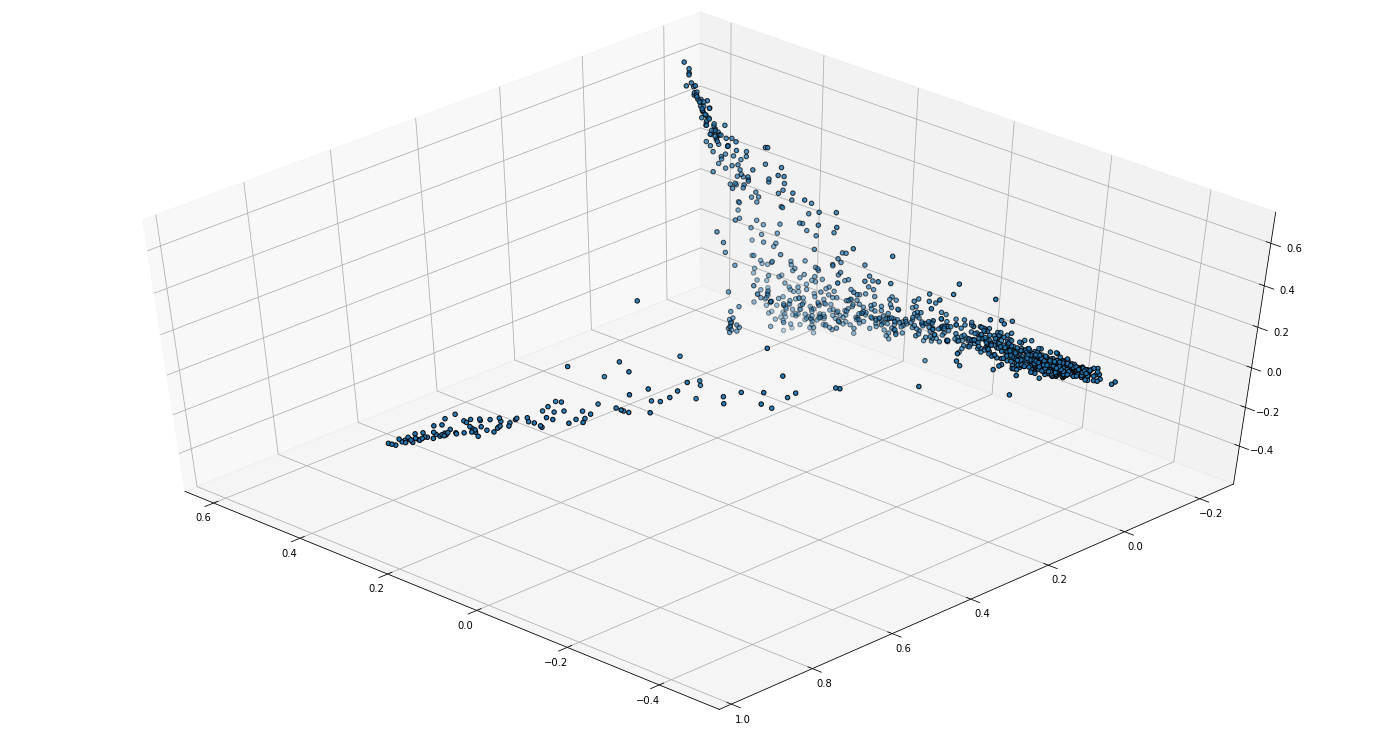

In [42]:
fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(vectors_vis["x"], vectors_vis["y"], vectors_vis["z"], cmap=plt.cm.nipy_spectral,
           edgecolor='k')

In [43]:
from sklearn.metrics import silhouette_score


Sum_of_squared_distances = []
sil  = []
K = range(2,6)

for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df_normalized)
    Sum_of_squared_distances.append(km.inertia_)
    labels = km.labels_
    sil.append(silhouette_score(df_normalized, labels, metric = 'euclidean'))

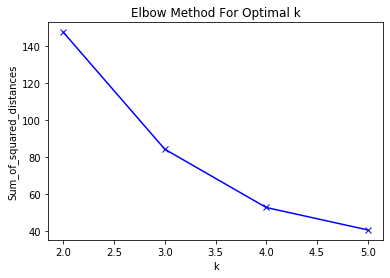

In [44]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

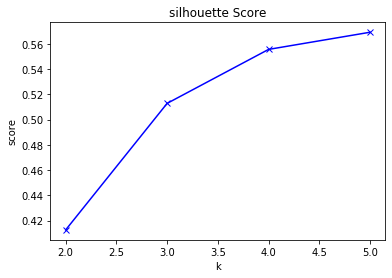

In [45]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('score')
plt.title('silhouette Score')
plt.show()

In [46]:
km = KMeans(n_clusters=5)
km.fit(df_normalized)
y = km.predict(df_normalized)

df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors_vis['Cluster Class'] = pd.Series(y, index=df_normalized.index)

C:\Users\gabi9\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



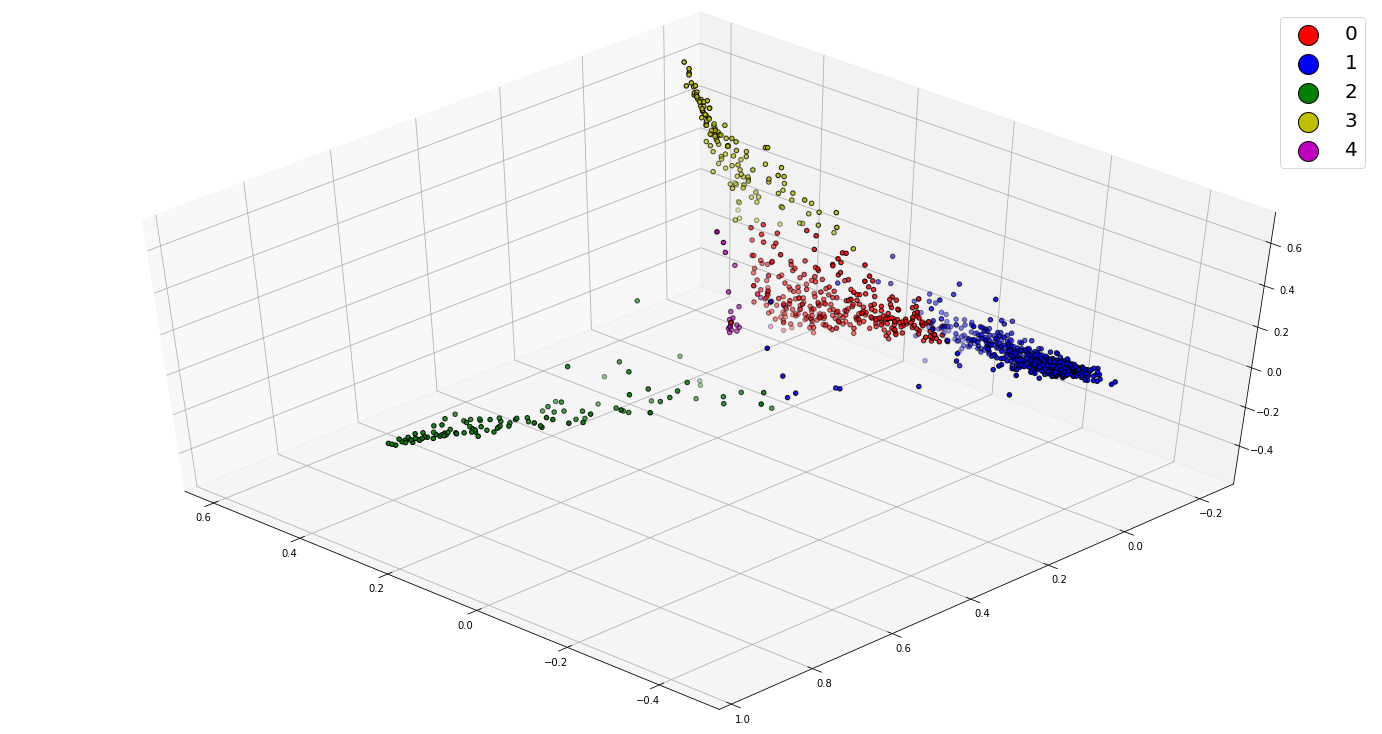

In [47]:
df = vectors_vis.groupby('Cluster Class')

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

colors = itertools.cycle(["r", "b", "g","y","m"])

for name,cluster in df:
    ax.scatter(cluster["x"], cluster["y"], cluster["z"], cmap=plt.cm.nipy_spectral,c=next(colors),
           edgecolor='k',label=name)

lgnd = plt.legend(prop={'size': 20})

#change the marker size manually for both lines
for legendHandle in lgnd.legendHandles:
    legendHandle._sizes = [400]

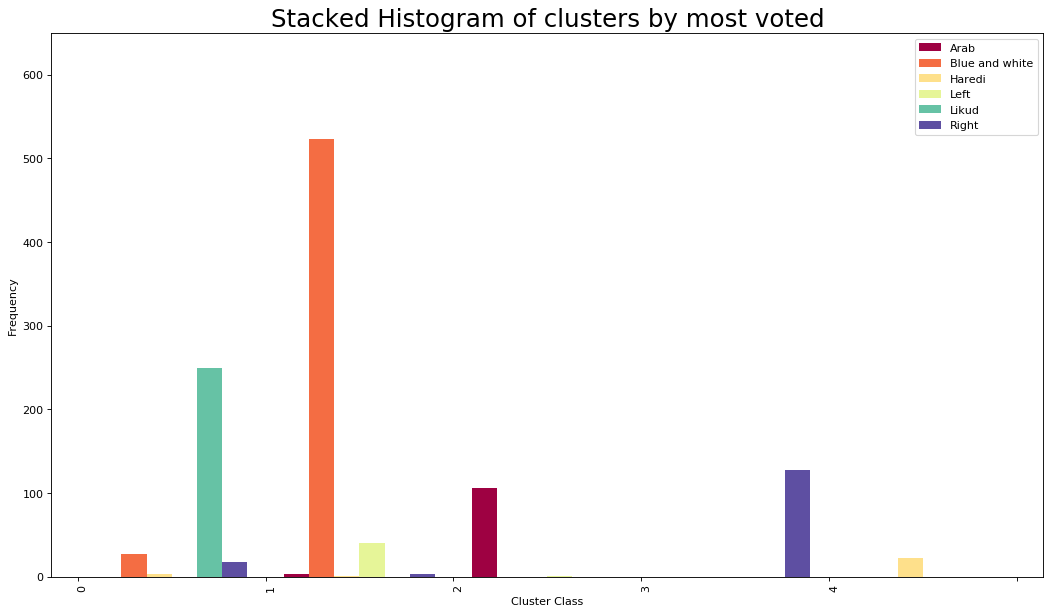

In [48]:
barchar_group(df_base,"Cluster Class","chosen",650,"Stacked Histogram of clusters by most voted")

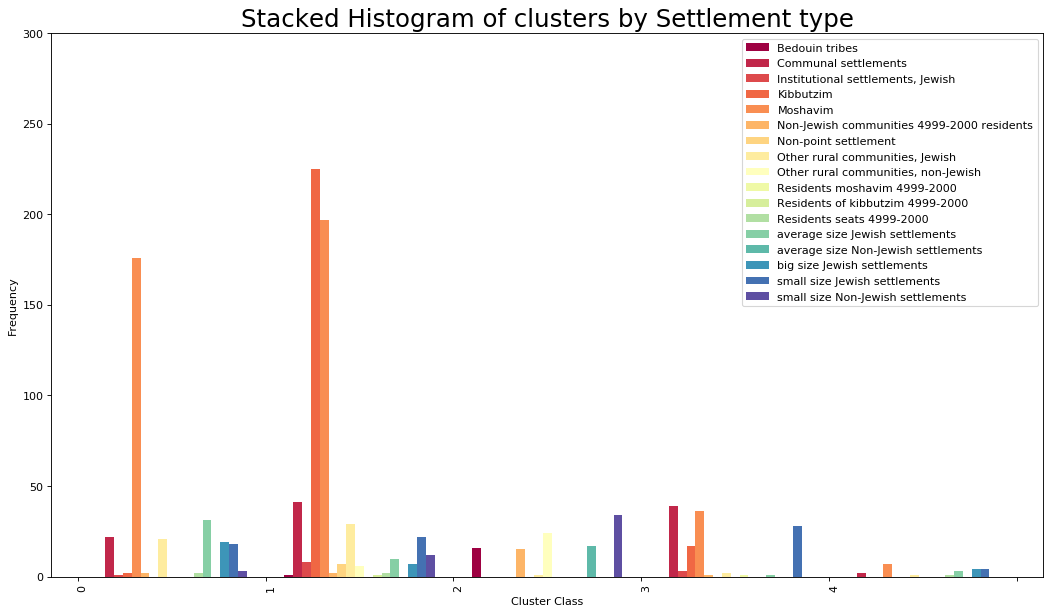

In [49]:
barchar_group(df_base,"Cluster Class","Settlement type",300, "Stacked Histogram of clusters by Settlement type")

In [50]:
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(df_normalized)
        bic_score = gmm.bic(df_normalized)
        if bic_score < lowest_bic:
            lowest_bic = bic_score
            best_gmm = gmm

y = gmm.predict(df_normalized)
df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors_vis['Cluster Class'] = pd.Series(y, index=df_normalized.index)

C:\Users\gabi9\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



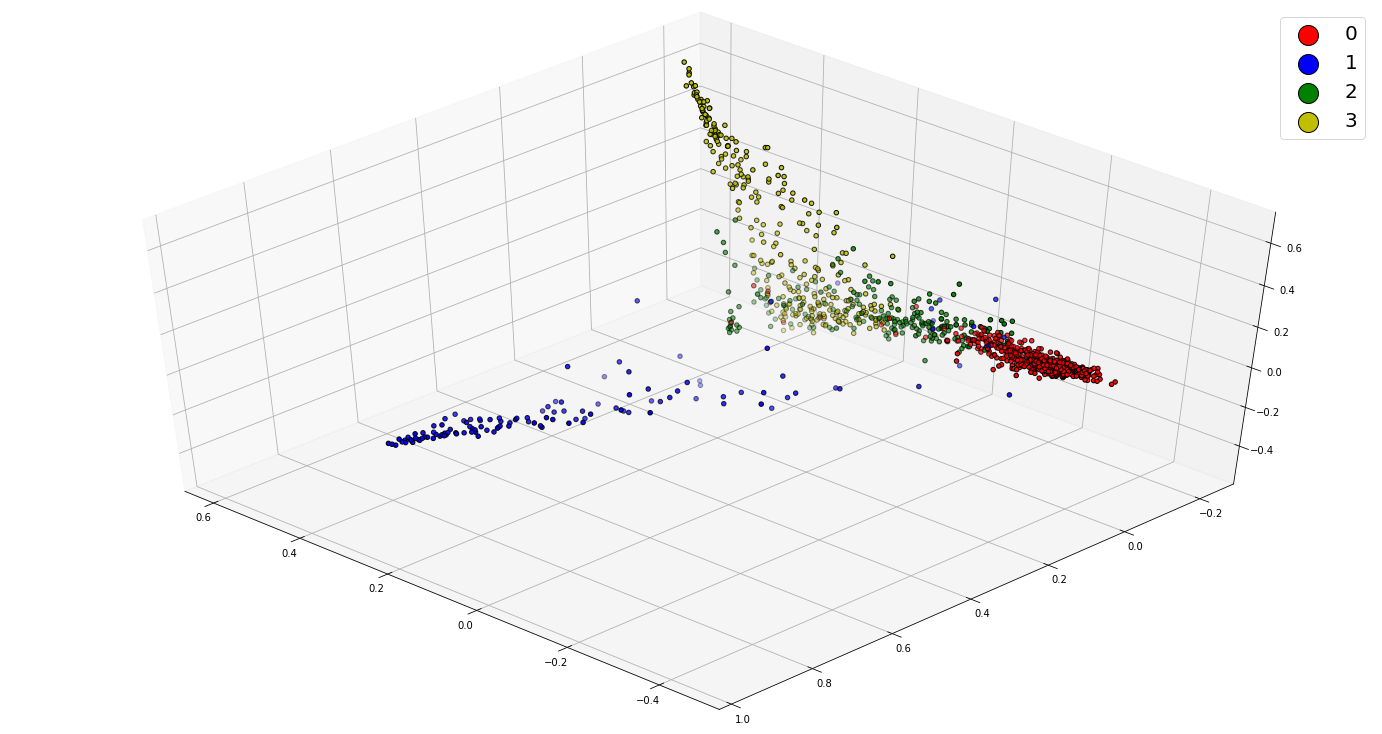

In [51]:
df = vectors_vis.groupby('Cluster Class')

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

colors = itertools.cycle(["r", "b", "g","y","m"])

for name,cluster in df:
    ax.scatter(cluster["x"], cluster["y"], cluster["z"], cmap=plt.cm.nipy_spectral,c=next(colors),
           edgecolor='k',label=name)

lgnd = plt.legend(prop={'size': 20})

#change the marker size manually for both lines
for legendHandle in lgnd.legendHandles:
    legendHandle._sizes = [400]

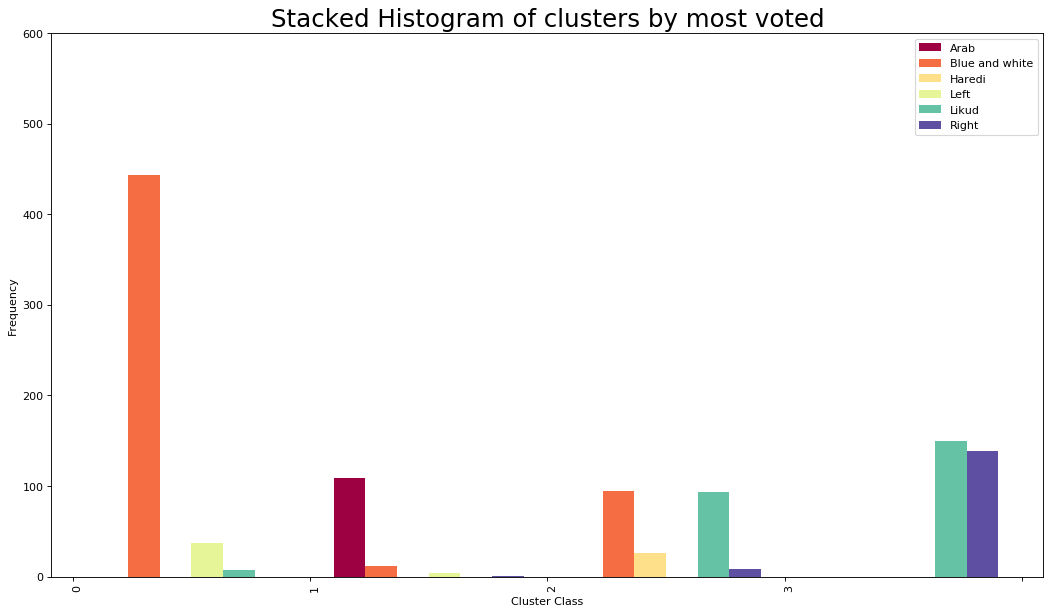

In [52]:
barchar_group(df_base,"Cluster Class","chosen",600,"Stacked Histogram of clusters by most voted")

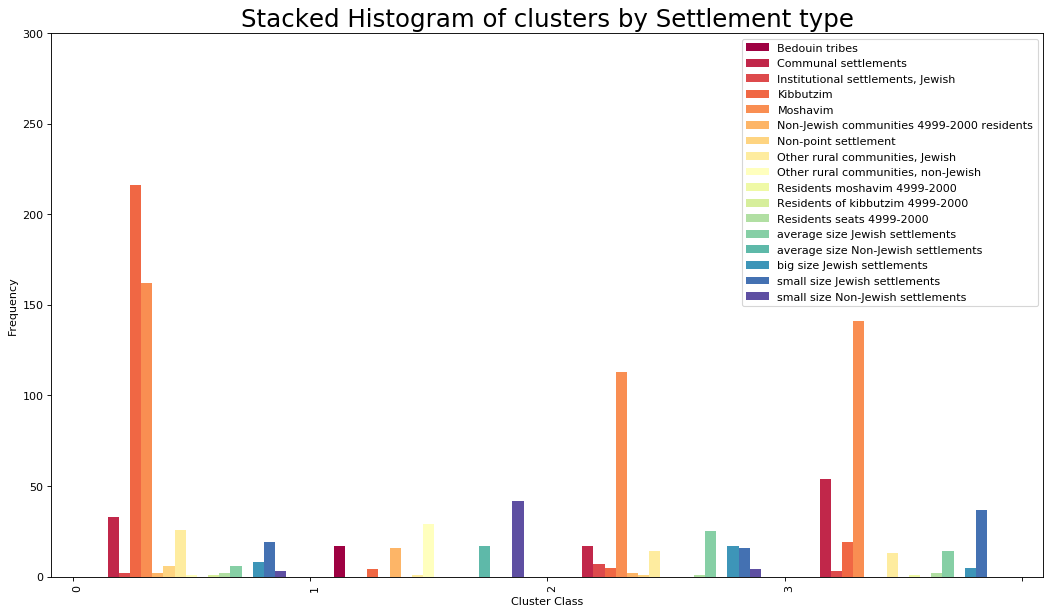

In [53]:
barchar_group(df_base,"Cluster Class","Settlement type",300,"Stacked Histogram of clusters by Settlement type")

# Question 4

In [54]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None,'log2'],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}


df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))
target = "valid votes"

df21 = inner_join(bycode,df21,"code")
df22 = inner_join(bycode,df22,"code")
df23 = inner_join(bycode,df23,"code")

df_train = pd.concat([df21, df22])

TEST=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df_test = df23[df23.name.isin(TEST)]
locations=df_test['name'].values.tolist()

# preparing data for training and testing
x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

# selecting features according to importance and transformig data accordingly
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)


# trainning model and testing
rs = GridSearchCV(RandomForestRegressor(random_state=SEED), param_grid, n_jobs=-1,
                        scoring='neg_mean_absolute_error', cv=5,
                        verbose=1)
rs.fit(x_train,y_train)
predict_y = rs.predict(x_test)

pred = pd.DataFrame(predict_y,columns=["prediction"],index = locations)
test = pd.DataFrame(y_test.values,columns=["actual"],index = locations)
        
results =  pd.concat([pred,test], axis=1)
results

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.5min finished


,prediction,actual
AYYELET HASHAHAR,580.0,585
ELAT,22699.0,22636
HAIFA,144310.0,144625
SAKHNIN,15833.0,17085
QAZRIN,3483.5,3498


In [55]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data', xaxis_title="Settlements",
    yaxis_title="Number of votes",)
fig.show()

# Question 5

In [70]:
from sklearn import  metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import RFECV


adb_param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                  'random_state': [1]}


# preparing data
df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))

df21 = inner_join(bycode,df21,"code")
df22 = inner_join(bycode,df22,"code")
df23 = inner_join(bycode,df23,"code")

df_train = pd.concat([df21, df22])

cities=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df_test = df23[df23.name.isin(cities)]

### Likud votes prediction

In [77]:
# model for likud
target = "Likud"

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]


sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(),param_grid = adb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print(metrics.mean_squared_error(y_test,y_predict))

pred = pd.DataFrame(y_predict,columns=["prediction"],index = cities)
test = pd.DataFrame(y_test.values,columns=["actual"],index = cities)
        
results =  pd.concat([pred,test], axis=1)
results


20406652.197084967


,prediction,actual
JERUSALEM,4229.000000,4951
BENE BERAQ,449.396761,407
SAKHNIN,62558.948718,72601
KARMI'EL,8172.628959,8879
DALIYAT AL-KARMEL,449.396761,39


In [78]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

### Blue and White predictions

In [79]:
# model for Blue and White
target = "Blue and white"

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]


sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(),param_grid = adb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print(metrics.mean_squared_error(y_test,y_predict))


pred = pd.DataFrame(y_predict,columns=["prediction"],index = cities)
test = pd.DataFrame(y_test.values,columns=["actual"],index = cities)
        
results =  pd.concat([pred,test], axis=1)
results

50677266.619078256


,prediction,actual
JERUSALEM,16083.005348,1133
BENE BERAQ,220.068088,5200
SAKHNIN,30568.333333,32800
KARMI'EL,6932.943820,6627
DALIYAT AL-KARMEL,220.068088,120


In [80]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

### Join list predictions

In [81]:

# model for Joint List
target = "Arabs"
x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]


sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(),param_grid = adb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print(metrics.mean_squared_error(y_test,y_predict))


pred = pd.DataFrame(y_predict,columns=["prediction"],index = cities)
test = pd.DataFrame(y_test.values,columns=["actual"],index = cities)
        
results =  pd.concat([pred,test], axis=1)
results


602096.6031530246


,prediction,actual
JERUSALEM,201.731122,64
BENE BERAQ,16650.542169,17382
SAKHNIN,349572.000000,349572
KARMI'EL,213.371648,1507
DALIYAT AL-KARMEL,31915.877551,31031


In [82]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import  metrics



le = LabelEncoder()

param_grid = {'n_estimators':[50,100,150,200,250,300], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

bycode = pd.read_excel(BYCODE)
sett_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
natru = pd.read_excel(INDEX,sheet_name=NATURAL)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21 = inner_join(df21,bycode,"code")
df21 = inner_join(df21,sett_type,"Settlement type code")
df21.fillna(0,inplace = True)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22 = inner_join(df22,bycode,"code")
df22 = inner_join(df22,sett_type,"Settlement type code")
df22.fillna(0,inplace = True)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = inner_join(df23,bycode,"code")
df23 = inner_join(df23,sett_type,"Settlement type code")
df23.fillna(0,inplace = True)

a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name_x.isin(a)]
locations=df23[['name_x']].values.tolist()

df=pd.concat([df21, df22])
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df23['Settlement type'] = le.fit_transform(df23['Settlement type'])


#Likud
colms= ["Likud","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Likud"]
x_train = df_temp.drop("Likud",axis = 1)
y_test = test["Likud"]
x_test = test.drop("Likud",axis=1)

rs = GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))


#Blue and white
colms= ["Blue and white","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Blue and white"]
x_train = df_temp.drop("Blue and white",axis = 1)
y_test = test["Blue and white"]
x_test = test.drop("Blue and white",axis=1)

rs =  GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))


#Arab
colms= ["Arab","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Arab"]
x_train = df_temp.drop("Arab",axis = 1)
y_test = test["Arab"]
x_test = test.drop("Arab",axis=1)

rs =  GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))





In [ ]:
from sklearn.ensemble import AdaBoostRegressor


def getdataRegress(num , RF ,n=None):
    
        df = get_data(SETTELMENT,num)
        df = remove_small_parties(df,135720)
        df = unite_parties(df)
        if RF:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes"]]
        if n == 1:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
        elif n == 2:
            return df[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
        else:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Left","valid votes","Arab"]

df21=getdataRegress(21,False,1)
df22=getdataRegress(22,False,1)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1



df21=getdataRegress(21,False,2)
df22=getdataRegress(22,False,2)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1







# Question 6

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import itertools

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)

df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)

bycode = pd.read_excel(BYCODE)
settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)

bycode.fillna(0,inplace = True)

def label(row,total):
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.01:
        val = 1
    
    return val

total = df21["Disqualified"].sum()
df21['class'] = df21.apply(lambda row : label(row, total), axis = 1) 
df = inner_join(df21,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df21 = df.drop(["code","name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1)




total = df22["Disqualified"].sum()
df22['class'] = df22.apply(lambda row : label(row, total), axis = 1)
df = inner_join(df22,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df22 = df.drop(["code","name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1)


df=pd.concat([df21, df22])
df= df.fillna(0)
y = df["class"]
x = df.drop("class",axis = 1)

rs.fit(x,y)

total = df23["Disqualified"].sum()
df23['class'] = df23.apply(lambda row : label(row, total), axis = 1) 
df = inner_join(df23,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df.drop(["name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1, inplace = True)
df= df.fillna(0)

test_y = df["class"]
test_x = df.drop("class",axis = 1)

y_predict = rs.predict(test_x)


In [85]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import itertools

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))
target = "class"
columns = np.append(features,target)

def label(row,total):
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.01:
        val = 1
    
    return val

def add_class(df):
    
    settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)

    total = df["Disqualified"].sum()
    df['class'] = df.apply(lambda row : label(row, total), axis = 1) 
    df = inner_join(df,bycode,"code")
    df = inner_join(df,settlment_type,"Settlement type code")
    df['Settlement type'] = le.fit_transform(df['Settlement type'])
    return df[columns]



In [91]:


df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)


df21 = add_class(df21)
df22 = add_class(df22)
df23 = add_class(df23)

df_train=pd.concat([df21, df22])

y_train = df_train[target]
x_train= df_train[features]

y_test = df23[target]
x_test = df23[features]


# Estimator for use in random search
rs = RandomizedSearchCV( RandomForestClassifier(random_state = SEED), param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)
rs.fit(x_train,y_train)


sfm = SelectFromModel(rs.estimator)
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

# Create the random search model
rs = RandomizedSearchCV(RandomForestClassifier(random_state = SEED), param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)
rs.fit(x_train,y_train)
y_predict = rs.predict(x_test)
print(metrics.accuracy_score(y_predict,y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


0.9991111111111111


Index(['District code', 'Subdistrict code', 'Natural area code',
       'Religion code', 'Total population in 2018', 'Jews and others',
       'Thereof: Jews', 'Arabs', 'Established', 'Settlement type code',
       'Organizational affiliation code', 'Coordinates', 'height',
       'Planning Commission', 'Space Police code', 'Local authorities code'],
      dtype='object')

Confusion matrix, without normalization


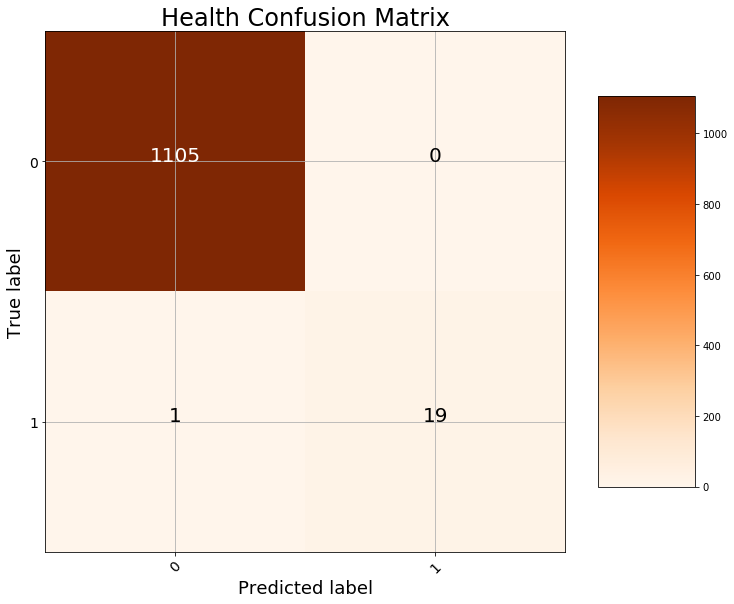

In [90]:
cm = confusion_matrix(test_y, y_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Health Confusion Matrix')